# Parallel Steps Execution in Agentic Systems in LangGraph


LangGraph provides robust support for parallel execution of nodes, enhancing the efficiency and performance of graph-based agentic workflows.

This parallelization is achieved through fan-out and fan-in mechanisms, and can utilize standard edges or conditional edges.


![](https://i.imgur.com/t44twOn.png)


## Install OpenAI, LangGraph and LangChain dependencies

In [1]:
!pip install langchain==0.3.14
!pip install langchain-openai==0.3.0
!pip install langchain-community==0.3.14
!pip install langgraph==0.2.64
!pip install wikipedia==1.4.0

      Successfully uninstalled langchain-0.3.15
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.6/142.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11679 sha256=9719d18bfcf27ff5110e625de127d1ba86817e02722d441fbf39f1f1f4cb283d
  Stored in directory: /root/.cache/pip/wheels/8f/ab/cb/45ccc40522d3a1c41e1d2ad53b8f33a62f394011ec38cd71c6
Successfully built wikipedia


## Enter Open AI API Key

In [2]:
from getpass import getpass

OPENAI_KEY = getpass('Enter Open AI API Key: ')

Enter Open AI API Key: ··········


## Enter Tavily Search API Key

Get a free API key from [here](https://tavily.com/#api)

In [3]:
TAVILY_API_KEY = getpass('Enter Tavily Search API Key: ')

Enter Tavily Search API Key: ··········


## Setup Environment Variables

In [4]:
import os

os.environ['OPENAI_API_KEY'] = OPENAI_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

## Simple Linear AI Workflow

Here we have a simple AI workflow which has a few sequential steps

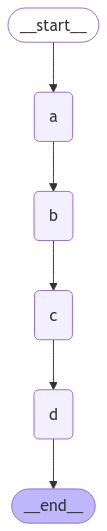

In [5]:
from IPython.display import Image, display

from typing import Any
from typing_extensions import TypedDict
from typing import Annotated
import operator
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    state: Annotated[list, operator.add]

class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['state']}")
        return {"state": [self._value]}

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("a", ReturnNodeValue("step A"))
builder.add_node("b", ReturnNodeValue("step B"))
builder.add_node("c", ReturnNodeValue("step C"))
builder.add_node("d", ReturnNodeValue("step D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("b", "c")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

We over-write state, as expected.

In [6]:
graph.invoke({"state": []})

Adding step A to []
Adding step B to ['step A']
Adding step C to ['step A', 'step B']
Adding step D to ['step A', 'step B', 'step C']


{'state': ['step A', 'step B', 'step C', 'step D']}

## Simple Linear AI Workflow with parallel steps

Key Concepts:
- Fan-Out: A process where a single node branches out to multiple nodes, allowing simultaneous execution of tasks. (Like a router node in router agents)
- Fan-In: A process where multiple nodes converge back into a single node, aggregating the results from parallel tasks.

Here we have a simple AI workflow which has a few parallel steps

We will run b and c in parallel and then run d.

We can do this easily with fan-out from a to b and c, and then fan-in to d.

The the state updates are applied at the end of each step.

When using fan out, we need to be sure that we are using a reducer if steps are writing to the same the channel / key.

When `operator.add` is applied to lists, it performs list concatenation.

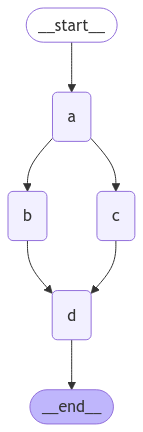

In [7]:
import operator
from typing import Annotated

class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    state: Annotated[list, operator.add]

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("a", ReturnNodeValue("step A"))
builder.add_node("b", ReturnNodeValue("step B"))
builder.add_node("c", ReturnNodeValue("step C"))
builder.add_node("d", ReturnNodeValue("step D"))

# Flow
builder.add_edge(START, "a")
# fan out
builder.add_edge("a", "b")
builder.add_edge("a", "c")
# fan in
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
graph.invoke({"state": []})

Adding step A to []
Adding step B to ['step A']
Adding step C to ['step A']
Adding step D to ['step A', 'step B', 'step C']


{'state': ['step A', 'step B', 'step C', 'step D']}

Now we see that we append to state for the updates made in parallel by `b` and `c`.

## Parallel AI Workflow with multiple steps

Now, lets consider a case where one parallel path has more steps than the other one.

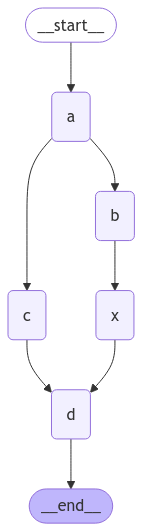

In [9]:
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("a", ReturnNodeValue("step A"))
builder.add_node("b", ReturnNodeValue("step B"))
builder.add_node("x", ReturnNodeValue("step X"))
builder.add_node("c", ReturnNodeValue("step C"))
builder.add_node("d", ReturnNodeValue("step D"))

# Flow
builder.add_edge(START, "a")
# fan out
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "x")
# fan in
builder.add_edge(["x", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In this case, `b`, `b2`, and `c` are all part of the same step.

The graph will wait for all of these to be completed before proceeding to step `d`.

In [10]:
graph.invoke({"state": []})

Adding step A to []
Adding step B to ['step A']
Adding step C to ['step A']
Adding step X to ['step A', 'step B', 'step C']
Adding step D to ['step A', 'step B', 'step C', 'step X']


{'state': ['step A', 'step B', 'step C', 'step X', 'step D']}

## Working with LLMs

Now, lets add a realistic example!

We want to gather context from two external sources (Wikipedia and Web-Seach) and have an LLM answer a question.

![](https://i.imgur.com/t44twOn.png)

### Define Agent State Schema

In [11]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [12]:
class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, operator.add]

### Define Node functions and Agent Graph

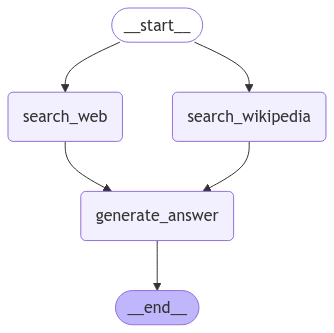

In [19]:
from langchain_core.messages import HumanMessage, SystemMessage

from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools import TavilySearchResults

def search_web(state):

    """ Retrieve docs from web search """
    print('--Getting Info from the Web--')

    # Search
    tavily_search = TavilySearchResults(max_results=3)
    search_docs = tavily_search.invoke(state['question'])

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'''Content: {doc['content']}\nSource: {doc['url']}'''
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

def search_wikipedia(state):

    """ Retrieve docs from wikipedia """
    print('--Getting Info from the Wikipedia--')

    # Search
    search_docs = WikipediaLoader(query=state['question'],
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'''Content: {doc.page_content}\nSource: {doc.metadata["source"]}'''
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

def generate_answer(state):

    """ Node to answer a question """
    print('--Generating final answer--')

    # Get state
    context = state["context"]
    question = state["question"]

    # Template
    answer_template = """Answer the question {question}
                         using these context documents: {context}"""
    answer_instructions = answer_template.format(question=question,
                                                       context=context)

    # Answer
    answer = llm.invoke([SystemMessage(content=answer_instructions)]+[HumanMessage(content=f"Answer the question.")])

    # Append it to state
    return {"answer": answer}

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("search_web",search_web)
builder.add_node("search_wikipedia", search_wikipedia)
builder.add_node("generate_answer", generate_answer)

# Flow
# fan out
builder.add_edge(START, "search_wikipedia")
builder.add_edge(START, "search_web")
# fan in
builder.add_edge("search_wikipedia", "generate_answer")
builder.add_edge("search_web", "generate_answer")
# aggregation
builder.add_edge("generate_answer", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

### Test Agent

In [20]:
result = graph.invoke({"question": "Tell me about Nvidia and its growth"})

--Getting Info from the Web--
--Getting Info from the Wikipedia--
--Generating final answer--


In [21]:
print(result['answer'].content)

Nvidia, founded on April 5, 1993, by Jensen Huang, Chris Malachowsky, and Curtis Priem, has experienced significant growth and transformation over the years. Initially, the company focused on developing graphics processing units (GPUs) and gained recognition with the release of the RIVA TNT in 1998. Nvidia went public in 1999, marking the beginning of its journey as a publicly traded company.

Under the leadership of CEO Jensen Huang, Nvidia has expanded its product offerings beyond gaming GPUs to include high-performance computing and artificial intelligence (AI) technologies. The company has positioned itself as a leader in the AI space, with its GPUs being widely adopted for deep learning applications by major companies like Microsoft, Google, and Toyota since 2017. This strategic pivot has contributed to Nvidia's remarkable financial growth, with revenues reaching $26.9 billion in FY22 and a market capitalization soaring from $364 billion to $1.87 trillion in just one year, making 